In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

## Data Preprocessing

In [2]:
# Load in the data
kaggle_fake_news = pd.read_csv('Data/kaggle/a2_Fake.csv')
kaggle_true_news = pd.read_csv('Data/kaggle/a1_True.csv')

# Add labels to each dataframe where 1 is fake and 0 is true
kaggle_fake_news['label'] = 1
kaggle_true_news['label'] = 0

# Concatenate the two dataframes
news = pd.concat([kaggle_fake_news, kaggle_true_news], axis=0)

In [3]:
pf_fake = pd.read_csv('Data/politifact/politifact_fake.csv')
pf_true = pd.read_csv('Data/politifact/politifact_real.csv')
pf_fake['label'] = 1
pf_true['label'] = 0
# Concatenate the two dataframes
politifact = pd.concat([pf_fake, pf_true], axis=0)

In [4]:
# Split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(news, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
class FakeNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.inputs = dataframe['title']
        self.labels = dataframe['label']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = self.inputs.iloc[idx]
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # shape: [max_length]
            'label': label
        }

In [7]:
train_dataset = FakeNewsDataset(train_df, tokenizer, 64)
val_dataset = FakeNewsDataset(val_df, tokenizer, 64)
test_dataset = FakeNewsDataset(test_df, tokenizer, 64)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
pf_test = FakeNewsDataset(politifact, tokenizer, 64)
pf_test_loader = DataLoader(pf_test, batch_size=32, shuffle=False)

## Model Arcitecture

In [4]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bidirectional=True)
        self.batchnorm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded) # Don't need to save the final hidden states from the LSTM block
        lstm_out = self.batchnorm(lstm_out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.fc(lstm_out[:, -1, :])
        return out

## Train and Test Loops

In [5]:
def trainloop(dataloader, model, loss_func, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_batches = len(dataloader)
    train_loss, train_acc = 0. , 0.
    model.train()
    for batch in dataloader:
        inputs = batch['input_ids']
        labels = batch['label']
        inputs = inputs.squeeze(1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
    return train_loss / num_batches, train_acc / len(dataloader.dataset)
    

def testloop(dataloader, model, loss_func):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_batches = len(dataloader)
    test_loss, test_acc = 0. , 0.
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids']
            labels = batch['label']
            inputs = inputs.squeeze(1).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()
            test_acc += (outputs.argmax(dim=1) == labels).sum().item()
    return test_loss / num_batches, test_acc / len(dataloader.dataset)

In [6]:
# Hyperparameters
lr = 1e-4
batch_size = 32
epochs = 25
max_len = 64

In [12]:
model = LSTM(vocab_size=tokenizer.vocab_size, embedding_dim=128, hidden_dim=64, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

model.to('cuda' if torch.cuda.is_available() else 'cpu')

LSTM(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [13]:
# Initialize lists before training
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

np.random.seed(42)

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0
best_epoch = 0
state_dict_to_save = model.state_dict()

for epoch in range(epochs):
    print(f"---Epoch {epoch+1}/{epochs}:---")

    train_loss, train_acc = trainloop(train_loader, model, loss_func, optimizer)
    val_loss, val_acc = testloop(val_loader, model, loss_func)

    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}.')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}.')

    # Early stopping check
    if val_loss < best_val_loss - 1e-6:  # Add small epsilon to avoid floating point issues
        best_val_loss = val_loss
        best_epoch = epoch
        state_dict_to_save = model.state_dict()
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
            break


---Epoch 1/25:---
Train Loss: 0.4893, Train Acc: 0.7287.
Validation Loss: 0.2916, Validation Acc: 0.8748.
---Epoch 2/25:---
Train Loss: 0.1979, Train Acc: 0.9205.
Validation Loss: 0.2015, Validation Acc: 0.9171.
---Epoch 3/25:---
Train Loss: 0.1217, Train Acc: 0.9553.
Validation Loss: 0.1489, Validation Acc: 0.9498.
---Epoch 4/25:---
Train Loss: 0.0951, Train Acc: 0.9651.
Validation Loss: 0.1199, Validation Acc: 0.9568.
---Epoch 5/25:---
Train Loss: 0.0784, Train Acc: 0.9717.
Validation Loss: 0.1197, Validation Acc: 0.9547.
---Epoch 6/25:---
Train Loss: 0.0619, Train Acc: 0.9782.
Validation Loss: 0.1194, Validation Acc: 0.9589.
---Epoch 7/25:---
Train Loss: 0.0518, Train Acc: 0.9827.
Validation Loss: 0.1004, Validation Acc: 0.9678.
---Epoch 8/25:---
Train Loss: 0.0405, Train Acc: 0.9872.
Validation Loss: 0.1387, Validation Acc: 0.9587.
No improvement in validation loss for 1 epoch(s).
---Epoch 9/25:---
Train Loss: 0.0313, Train Acc: 0.9898.
Validation Loss: 0.1130, Validation Acc: 0.96

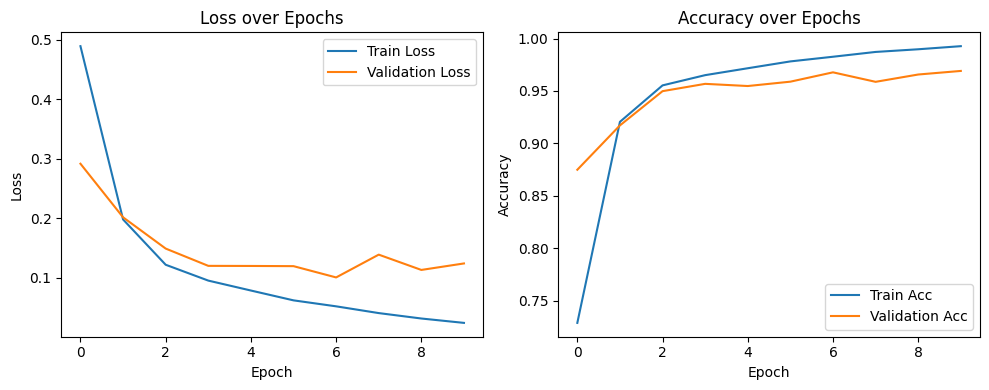

In [14]:
# Plotting loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


We see overfitting when increasing the trainig Epochs. This is not surprising as LSTM blocks are prone to overfitting. Even with adding dropouts in the LSTM block we see overfitting at about the 10th epoch of training.

In [15]:
model.load_state_dict(state_dict_to_save)

<All keys matched successfully>

In [16]:
test_loss, test_acc = testloop(pf_test_loader, model, loss_func)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Test Loss: 1.5640305443243547, Test Accuracy: 0.7026515151515151


The model trainied on only Kaggle data underperforms heavily on the politifact dataset. This likely has to do with the datasets being different in terms of relevancy and content.

In [17]:
torch.save(model.state_dict(), "./model_parameters/LSTM_bidirectional-kaggle-train.pth")

### Train on Politifact and Kaggle

In [7]:
# Load in the data
kaggle_fake_news = pd.read_csv('Data/kaggle/a2_Fake.csv')
kaggle_true_news = pd.read_csv('Data/kaggle/a1_True.csv')

# Add labels to each dataframe where 1 is fake and 0 is true
kaggle_fake_news['label'] = 1
kaggle_true_news['label'] = 0

# Concatenate the two dataframes
news = pd.concat([kaggle_fake_news, kaggle_true_news], axis=0)[['title', 'label']]

In [8]:
pf_fake = pd.read_csv('Data/politifact/politifact_fake.csv')
pf_true = pd.read_csv('Data/politifact/politifact_real.csv')
pf_fake['label'] = 1
pf_true['label'] = 0
# Concatenate the two dataframes
politifact = pd.concat([pf_fake, pf_true], axis=0)[['title', 'label']]

In [9]:
print(f"Proportion of Fake News labels in Kaggle: {round(sum(news['label']) / len(news), 2)}.")
print(f"Proportion of Fake News labels in Politifact: {round(sum(politifact['label']) / len(politifact), 2)}.")

Proportion of Fake News labels in Kaggle: 0.52.
Proportion of Fake News labels in Politifact: 0.41.


In [10]:
kaggle_train, kaggle_test = train_test_split(news, test_size=0.15, random_state=42, shuffle=True)
politifact_train, politifact_test = train_test_split(politifact, test_size=0.15, random_state=42, shuffle=True)
kaggle_train, kaggle_val = train_test_split(kaggle_train, test_size=0.15, random_state=42, shuffle=True)
politifact_train, politifact_val = train_test_split(politifact_train, test_size=0.15, random_state=42, shuffle=True)
full_train = pd.concat([kaggle_train, politifact_train], axis=0)
full_val = pd.concat([kaggle_val, politifact_val], axis=0)
full_test = pd.concat([kaggle_test, politifact_test], axis=0)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [12]:
train_dataset = FakeNewsDataset(full_train, tokenizer, 64)
val_dataset = FakeNewsDataset(full_val, tokenizer, 64)
kaggle_test_dataset = FakeNewsDataset(kaggle_test, tokenizer, 64)
politifact_test_dataset = FakeNewsDataset(politifact_test, tokenizer, 64)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
kaggle_test_loader = DataLoader(kaggle_test_dataset, batch_size=32, shuffle=False)
politifact_test_loader = DataLoader(politifact_test_dataset, batch_size=32, shuffle=False)

In [13]:
# Hyperparameters
lr = 1e-4
batch_size = 32
epochs = 25
max_len = 64

In [14]:
model = LSTM(vocab_size=tokenizer.vocab_size, embedding_dim=128, hidden_dim=64, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

model.to('cuda' if torch.cuda.is_available() else 'cpu')

LSTM(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [15]:
# Initialize lists before training
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

np.random.seed(42)

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0
best_epoch = 0
state_dict_to_save = model.state_dict()

for epoch in range(epochs):
    print(f"---Epoch {epoch+1}/{epochs}:---")

    train_loss, train_acc = trainloop(train_loader, model, loss_func, optimizer)
    val_loss, val_acc = testloop(val_loader, model, loss_func)

    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}.')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}.')

    # Early stopping check
    if val_loss < best_val_loss - 1e-6:  # Add small epsilon to avoid floating point issues
        best_val_loss = val_loss
        best_epoch = epoch
        state_dict_to_save = model.state_dict()
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
            break


---Epoch 1/25:---
Train Loss: 0.6966, Train Acc: 0.5164.
Validation Loss: 0.6948, Validation Acc: 0.5225.
---Epoch 2/25:---
Train Loss: 0.6901, Train Acc: 0.5337.
Validation Loss: 0.6941, Validation Acc: 0.5225.
---Epoch 3/25:---
Train Loss: 0.6879, Train Acc: 0.5417.
Validation Loss: 0.6921, Validation Acc: 0.5225.
---Epoch 4/25:---
Train Loss: 0.3208, Train Acc: 0.8326.
Validation Loss: 0.1636, Validation Acc: 0.9406.
---Epoch 5/25:---
Train Loss: 0.1275, Train Acc: 0.9543.
Validation Loss: 0.1238, Validation Acc: 0.9558.
---Epoch 6/25:---
Train Loss: 0.1034, Train Acc: 0.9639.
Validation Loss: 0.1165, Validation Acc: 0.9575.
---Epoch 7/25:---
Train Loss: 0.0858, Train Acc: 0.9714.
Validation Loss: 0.1061, Validation Acc: 0.9613.
---Epoch 8/25:---
Train Loss: 0.0705, Train Acc: 0.9774.
Validation Loss: 0.1182, Validation Acc: 0.9575.
No improvement in validation loss for 1 epoch(s).
---Epoch 9/25:---
Train Loss: 0.0585, Train Acc: 0.9814.
Validation Loss: 0.1009, Validation Acc: 0.96

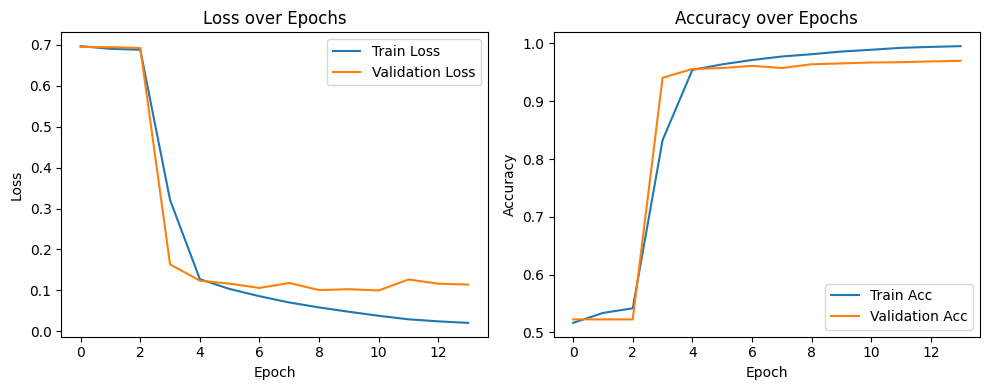

In [17]:
# Plotting loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
model.load_state_dict(state_dict_to_save)

<All keys matched successfully>

In [20]:
kaggle_test_loss, kaggle_test_acc = testloop(kaggle_test_loader, model, loss_func)
print(f"Kaggle Test Loss: {kaggle_test_loss}, Test Accuracy: {kaggle_test_acc}")

Kaggle Test Loss: 0.11367945337581992, Test Accuracy: 0.9679287305122495


In [21]:
politifact_test_loss, politifact_test_acc = testloop(politifact_test_loader, model, loss_func)
print(f"Politifact Test Loss: {politifact_test_loss}, Test Accuracy: {politifact_test_acc}")

Politifact Test Loss: 0.9469716787338257, Test Accuracy: 0.7610062893081762


The model performs better on the Politifact dataset when it's included in training. This is expected. However, the improvement is small, likely because the Kaggle dataset is substantially larger than the Politifact dataset. This means that the model is better at learning how to identify Fake News based on the Kaggle dataset compared to the Politifact dataset.

In [22]:
torch.save(model.state_dict(), './model_parameters/LSTM-bidirectional-both-datasets-training.pth')

## Transfer Learning

In this section, we will explore transfer learning on the Politifact dataset following training on the Kaggle dataset.

In [23]:
pf_fake = pd.read_csv('Data/politifact/politifact_fake.csv')
pf_true = pd.read_csv('Data/politifact/politifact_real.csv')
pf_fake['label'] = 1
pf_true['label'] = 0
# Concatenate the two dataframes
politifact = pd.concat([pf_fake, pf_true], axis=0)

In [24]:
# Split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(politifact, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = FakeNewsDataset(train_df, tokenizer, 64)
val_dataset = FakeNewsDataset(val_df, tokenizer, 64)
test_dataset = FakeNewsDataset(test_df, tokenizer, 64)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
# Hyperparameters
lr = 1e-4
batch_size = 32
epochs = 25
max_len = 64

In [27]:
model = LSTM(vocab_size=tokenizer.vocab_size, embedding_dim=128, hidden_dim=64, output_dim=2)
model.load_state_dict(torch.load('./model_parameters/LSTM_bidirectional-kaggle-train.pth', map_location='cpu'))
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

model.to('cuda' if torch.cuda.is_available() else 'cpu')

LSTM(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [28]:
# Initialize lists before training
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

np.random.seed(42)

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0
best_epoch = 0
state_dict_to_save = model.state_dict()

for epoch in range(epochs):
    print(f"---Epoch {epoch+1}/{epochs}:---")

    train_loss, train_acc = trainloop(train_loader, model, loss_func, optimizer)
    val_loss, val_acc = testloop(val_loader, model, loss_func)

    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}.')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}.')

    # Early stopping check
    if val_loss < best_val_loss - 1e-6:  # Add small epsilon to avoid floating point issues
        best_val_loss = val_loss
        best_epoch = epoch
        state_dict_to_save = model.state_dict()
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
            break


---Epoch 1/25:---
Train Loss: 0.9065, Train Acc: 0.7334.
Validation Loss: 0.7648, Validation Acc: 0.5443.
---Epoch 2/25:---
Train Loss: 0.5614, Train Acc: 0.7348.
Validation Loss: 0.6161, Validation Acc: 0.7089.
---Epoch 3/25:---
Train Loss: 0.5244, Train Acc: 0.7402.
Validation Loss: 0.6638, Validation Acc: 0.7152.
No improvement in validation loss for 1 epoch(s).
---Epoch 4/25:---
Train Loss: 0.5153, Train Acc: 0.7781.
Validation Loss: 0.6484, Validation Acc: 0.7152.
No improvement in validation loss for 2 epoch(s).
---Epoch 5/25:---
Train Loss: 0.5414, Train Acc: 0.7673.
Validation Loss: 0.6118, Validation Acc: 0.7342.
---Epoch 6/25:---
Train Loss: 0.4807, Train Acc: 0.7862.
Validation Loss: 0.6283, Validation Acc: 0.7215.
No improvement in validation loss for 1 epoch(s).
---Epoch 7/25:---
Train Loss: 0.4767, Train Acc: 0.7957.
Validation Loss: 0.6016, Validation Acc: 0.7215.
---Epoch 8/25:---
Train Loss: 0.4506, Train Acc: 0.8146.
Validation Loss: 0.5771, Validation Acc: 0.7405.
--

In [29]:
test_loss, test_acc = testloop(test_loader, model, loss_func)
print(f"Politifact Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Politifact Test Loss: 0.5694141447544098, Test Accuracy: 0.7547169811320755


Transfer learning does not help the model improve on the Politifact dataset.

In [30]:
torch.save(model.state_dict(), "./model_parameters/LSTM_bidirectional-transfer-learning.pth")